### Import

#### pip install

In [1]:
!pip install keras_tuner
!pip install livelossplot

In [2]:
from pathlib import Path
import re
import random
import math
import functools
import shutil
import os
import itertools
import datetime
import time

import IPython
from IPython.display import Image, display
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import PIL.Image
import pickle

#
import numpy as np
import pandas as pd
from skimage import exposure
import tensorflow as tf
import tensorflow.keras.applications as tfkapp
import keras_tuner
import tensorflow_hub as tfhub

import livelossplot

#### Constants

In [3]:
DEV = True

#common paths
C_PATH      = Path('/kaggle/working') 
IMG_PATH    = C_PATH  / 'Images/'
P6_PATH     = C_PATH 
LOG_PATH    = C_PATH  / 'logs/'
TUNER_PATH  = C_PATH  / 'tuner/'

# flag to force sampling
FORCE_TEST_SAMPLING = False
FORCE_DEV_SAMPLING = False

# random seed
SEED = 123

TRAIN_SIZE  = 0.75
VAL_SIZE    = 0.15
TEST_SIZE   = 0.10
BATCH_SIZE  = 24
IMG_SIZE    = (224,224)

# Images for dev path (limited number of class)
I_PATH2 = C_PATH / 'Images-dev/'
# Images for dev path (limited number of class)
T_PATH2 = C_PATH / 'Images-tst-dev/'
# num classes
NUM_CLASSES2 = 3

# Images path
I_PATH = C_PATH / 'Images/'
# Images for testing path
T_PATH = C_PATH / 'Images-test/'
# num classes
NUM_CLASSES = 120

# random seed
def set_seed(seed):
  tf.random.set_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

set_seed(SEED)

# directories handling
rm_dir  = lambda dir: shutil.rmtree(dir) if (dir is not None and dir.exists()) else None

def exec_time(start, end):
   diff_time = end - start
   m, s = divmod(diff_time, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   time_span = "{0:02d}:{1:02d}:{2:02d}".format(h, m, s)
   print(f"Execution Time: {time_span}")
   return diff_time

trainableParams    = lambda model: np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
nonTrainableParams = lambda model: np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])


In [4]:
# run tf functions eagerly
tf.config.run_functions_eagerly(True)

#interop threads (to run different graph)
tf.config.threading.set_inter_op_parallelism_threads(2)

#interop threads (to run within a graph)
tf.config.threading.set_intra_op_parallelism_threads(3)

### Manage directories

In [5]:
! cp -r /kaggle/input/standforddogs/Images/  /kaggle/working

#### class ImgDir

In [6]:
class ImgDir:
  def __init__(self,root,seed):
    self.root             = root
    self.test_dir         = self.root / '../Images-test/'
    self.dev_dir          = self.root / '../Images-dev/'
    self.dev_test_dir     = self.root / '../Images-tst-dev/'

    self.all_images       = lambda : list(self.root.glob('*/*.jpg'))
    self.images           = lambda dir: dir.glob('*.jpg')
    self.rm               = lambda dir: shutil.rmtree(dir) if (dir is not None and dir.exists()) else None
    self.image_count      = lambda dir: len(list(self.images(dir)))  
    self.breed_annotation = {t[2]:t[1] for t in [ re.split('(n[0-9]*)-(.*)',dir.name) for dir in self.root.iterdir()]}
    self.breed_dir        = lambda breed: self.root / f"{self.breed_annotation[breed]}-{breed}"\
                               if self.breed_annotation.get(breed) is not None\
                               else None
    self.breeds           = list(self.breed_annotation.keys())
    self.random_from_list = lambda l: l[random.randrange(0,len(l))]
    
    # generate seed for each breed
    N = 1000
    self.seeds = {breed: random.randrange(N) for breed in self.breeds}
    self.seeds['dev'] = random.randrange(N)

  def clean(self,dir):
    self.rm(dir)
    os.mkdir(dir)

  def path(self,id='random',breed=None):
    if id == 'random' and breed is None:
      return self.random_from_list(list(self.all_images()))
    elif breed is not None:
      dir = self.breed_dir(breed)
      if dir is None:
        print(f'unknown breed: {breed}')
        return
      else:
        if id == 'random':
          return self.random_from_list(list(self.images(dir)))
        else:
            l= list(self.root.glob(f'*{breed}/*_{id}.jpg'))
            if len(l) > 0:
              return l[0]
            else:
              print(f"can't find img with id {id} for {breed}")
    else:
      l= list(self.root.glob(f'*/*_{id}.jpg'))
      if len(l) > 0:
        return l
      else:
        print(f"can't find img with id {id}")
  
  def breed_samples(self,breed,p):
    prop = lambda p,n: math.floor(p*n) if math.floor(p*n) > 0 else math.ceil(p*n)
    # images for the given breed
    imgs = list(self.images(self.breed_dir(breed)))
    n = len(imgs)
    #set seed
    random.seed(self.seeds[breed])
    #select images randomly
    r = range(n)
    k = prop(n,p)
    return [imgs[i] for i in random.sample(r,k)]
  
  def dst_dir(self,root_dst,breed):
    bdir = self.breed_dir(breed).parts[-1]
    return root_dst / bdir
  
  #def test_samples(self,root_dst,p):
  #  for breed in self.breeds:
  #    # dest dir for the given breed
  #    ddir = self.dst_dir(root_dst,breed)
  #    os.mkdir(ddir)
  #    for f in self.breed_samples(breed,p):
  #      shutil.move(src=str(f),dst=str(ddir))

  def test_samples(self,p,force=False,root_dst=None):
    if self.test_dir.exists() and force == False:
      print("NO test sampling executed")
    else:
      #self.test_dir = root_dst if root_dst is not None else self.test_dir
      self.clean(self.test_dir)
      for breed in self.breeds:
        # dest dir for the given breed
        ddir = self.dst_dir(self.test_dir,breed)
        os.mkdir(ddir)
        for f in self.breed_samples(breed,p):
          shutil.move(src=str(f),dst=str(ddir))
      print("Test sampling executed")

  def dev_samples(self,num_class,force=False):
    if self.dev_dir.exists() and self.dev_test_dir.exists() and force == False:
      print("NO dev sampling executed")
    else:    
      random.seed(self.seeds['dev'])
      selected_breeds  = [self.random_from_list(self.breeds) for i in range(num_class)]
      selected_dirs    = [ f"{self.breed_annotation[breed]}-{breed}" for breed in selected_breeds]
      # create directories
      self.clean(self.dev_dir)
      self.clean(self.dev_test_dir)
      for dir in selected_dirs:
        # copy dev
        #os.mkdir(self.dev_dir / dir)
        shutil.copytree(self.root/dir,self.dev_dir/dir)
        # copy test
        #os.mkdir(self.dev_test_dir / dir,)
        shutil.copytree(self.test_dir/dir, self.dev_test_dir/dir)
      print(f"Dev sampling executed - selected breeds: {selected_breeds}")
    
img_dir = ImgDir(IMG_PATH,SEED)

# Remove RGBA picture
img_open = lambda p: PIL.Image.open(str(p),'r')
img_info = lambda img,info: {'mode':img.mode,'height':img.height,'width':img.width}[info]

for p in img_dir.all_images():
  if img_info(img_open(p),'mode') == 'RGBA':
    print(f"remove image: {p}")
    p.unlink()

remove image: /kaggle/working/Images/n02105855-Shetland_sheepdog/n02105855_2933.jpg


#### Create test and dev samples

In [7]:
img_dir.test_samples(TEST_SIZE,FORCE_TEST_SAMPLING)
img_dir.dev_samples(NUM_CLASSES2,FORCE_DEV_SAMPLING)

! find /kaggle/working/Images/ -type f | wc -l
! find /kaggle/working/Images-test/ -type f | wc -l
! find /kaggle/working/Images-dev/ -type f | wc -l
! find /kaggle/working/Images-tst-dev/ -type f | wc -l

Test sampling executed
Dev sampling executed - selected breeds: ['French_bulldog', 'Yorkshire_terrier', 'bluetick']
18570
2009
446
48


### Datasets

#### Preprocess layers

In [8]:
def select_dim(i,s):
  tmp = np.zeros(shape=s)
  tmp[:,:,i] = 1.0
  return tmp

def equalize(img):
    #print(f"shape: {img.shape} {type(img)}")
    s = img.shape
    for i in range(3):
      img[:,:,i] = exposure.equalize_hist(img,mask=select_dim(i,s))[:,:,i]
    return img

@tf.function (input_signature=[tf.TensorSpec(shape=(None,None,3), dtype=tf.float32)])
def tf_equalize(img):
  with tf.init_scope():
    return equalize(img.numpy())

class Equalize(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
      super(Equalize, self).__init__(**kwargs)

    def call(self, inputs,train=False):
        return tf_equalize(inputs)
    
    def compute_output_signature(self,input_signature):
      return input_signature

#rescale
rescale_layer = tf.keras.layers.Rescaling(scale=(1./255))
rescale = lambda ds: ds.map( lambda x, y: (rescale_layer(x), y))

#equalize layer
equalize_layer = Equalize()
eq = lambda ds: ds.map( lambda x, y: (equalize_layer(x), y))

# data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomContrast(factor=0.2),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(factor=0.2,fill_mode='nearest'),
  tf.keras.layers.RandomZoom(height_factor=0.2,width_factor=0.2,fill_mode='nearest'),
  tf.keras.layers.RandomTranslation(height_factor=0.2,width_factor=0.2,fill_mode='nearest')
])
aug_ds = lambda ds: ds.map( lambda x, y: ( data_augmentation(x), y) )

# apply_preprocess
def apply_preprocess(preprocesses,dss):
  tmp = dss
  for preprocess in preprocesses:
    tmp = list(map(preprocess,tmp))
  return tmp

#performance
def configure_for_performance(ds):
  #ds = ds.cache() (OOM)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

perf = lambda dss: list(map(configure_for_performance,dss))


2022-07-14 22:36:23.043070: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 22:36:23.145756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 22:36:23.146538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 22:36:23.148600: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

#### function dataset_from_dir

In [9]:
# resizing is part of the dataset definition. So will be automatically used for 
# fitting. will need to add that to preprocessing layer when using the model
def dataset_from_dir(dir,
                     subsets = ["training","validation"],
                     validation_split=VAL_SIZE,
                     batch_size=BATCH_SIZE,
                     image_size=IMG_SIZE,
                     ):
  return list(map(
    lambda subset: tf.keras.utils.image_dataset_from_directory(
                                                    directory=dir,
                                                    labels='inferred',
                                                    label_mode='categorical',
                                                    class_names=None,
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    image_size=image_size,
                                                    shuffle=True,
                                                    seed=SEED,
                                                    validation_split=validation_split,
                                                    subset=subset,
                                                    interpolation='bilinear',
                                                    follow_links=False,
                                                    crop_to_aspect_ratio=False
                                                  ),
                    subsets
    ))


#
#  get_data_sets
#
def get_data_sets(train_actions,tst_val_actions,pref=True,dev=False,ret='tuple'):

  do_perf = lambda dss: perf(dss) if pref is True else dss
                             
  if  dev is True:
    (train_ds,val_ds) = dataset_from_dir(I_PATH2)
    (test_ds,) = dataset_from_dir(T_PATH2,subsets=[None],validation_split=None)
  else:
    (train_ds,val_ds) = dataset_from_dir(I_PATH)
    (test_ds,) = dataset_from_dir(T_PATH,subsets=[None],validation_split=None)

  if train_actions is not None:
   [train_ds] = apply_preprocess(train_actions,do_perf([train_ds]))

  if tst_val_actions is not None:
    [val_ds,test_ds] = apply_preprocess(tst_val_actions,do_perf([val_ds,test_ds]))

  if ret == 'dict':
    return {'train_ds':train_ds,'val_ds':val_ds,'test_ds':test_ds}
  else:
    return (train_ds,val_ds,test_ds)


### Train models

#### Common definitions

##### hyper-model and hyper-parameters

In [10]:
# hyperparameters accesssors according to mode
def rate_i(hp,mode,i,v):
  rate_name = f"rate_{str(i)}"
  if mode == "tune":
    #return  hp.Choice(name = rate_name, values = v)
    return  hp.Float(name = rate_name, min_value=v[0], max_value=v[1], sampling="linear")
  else:
    return  hp.get(name = rate_name)

def learning_rate(hp,mode):
  if mode == "tune":
    return hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  else:
    return hp.get("lr")

def activation(hp,mode,i):
  if mode == "tune":
    return hp.Choice(f"act_{i}", values = ['relu','tanh'])
  else:
    return hp.get(f"act_{i}")

# hyper model
def hyper_model_gen(hp,model_name,mode,num_classes,models):

  model = (models.get(model_name))(hp,mode,num_classes)

  if model is None:
    raise Exception(f"Unknown model {model_name}")

  return model


##### Définition des layers

In [11]:
# convolution_relu 
convolution_relu = functools.partial(tf.keras.layers.Conv2D, kernel_size=3, activation='relu', padding="same")
# convolution 
convolution = functools.partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same")
# max_pooling
max_pooling = functools.partial(tf.keras.layers.MaxPooling2D, pool_size=(2,2), strides=(2,2))
# fully_connected
fully_connected = functools.partial(tf.keras.layers.Dense,units=4096, activation='relu')
# fully_connected
hp_fully_connected = functools.partial(tf.keras.layers.Dense,units=4096)
# soft_max
soft_max = functools.partial(tf.keras.layers.Dense, activation = 'softmax')

##### Check points and directory related functions

In [12]:
my_time_stamp = lambda : f'{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
log_dir       = lambda name: str( LOG_PATH / f'{name}_{my_time_stamp()}')
model_file    = lambda name: f"{name}.h5" if DEV is False else f"{name}_{my_time_stamp()}_dev.h5"
model_path    = lambda name: str(P6_PATH / f'models/{model_file(name)}')

#https://keras.io/api/callbacks/model_checkpoint/
#checkpoint
checkpoint = functools.partial(tf.keras.callbacks.ModelCheckpoint,monitor='val_accuracy',mode='max',save_best_only=True,verbose=1)
mk_checkpoint_cb = lambda path: checkpoint(filepath=path)

#tensorboard (OOM)
# mk_tensorboard_cb = lambda name: tf.keras.callbacks.TensorBoard(log_dir=log_dir(name), histogram_freq=1)

##### fit_and_evaluate | tune_fit_and_evaluate

In [13]:
def fit_and_evaluate(model,model_name,train_ds,val_ds,test_ds,patience=5,min_delta=0.001,max_epochs=100):
  
  #callbacks
  m_path_str        = model_path(model_name)
  #checkpoint_cb     = mk_checkpoint_cb(m_path_str)
  early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',patience=patience,min_delta=min_delta,restore_best_weights=True,verbose=1) 
  callbacks         = [early_stopping_cb,livelossplot.PlotLossesKeras()] # checkpoint_cb,
  
  #fit model
  history = model.fit(
                  x=train_ds,
                  epochs=max_epochs,
                  steps_per_epoch=None,
                  validation_data=val_ds,
                  callbacks=callbacks)
  
  # load best model
  best_model = None
  if(Path(m_path_str).exists()):
    print(f"\n===== Load best model from: {m_path_str} =====\n")
    best_model= tf.keras.models.load_model(m_path_str,custom_objects={'Equalize':Equalize})
  else:
    best_model = model

  #evalute
  evaluation = best_model.evaluate(test_ds)
  print("\n===== EVALUATE =====\n")
  print(f"test loss, test acc: {evaluation}")
  print("\n====================\n")
  
  # display model
  fig = tf.keras.utils.plot_model(best_model, to_file=f'/kaggle/working/{model_name}.png', show_shapes=True)
    
  #
  return (history,evaluation,trainableParams(best_model),fig)


def tune_fit_and_evaluate(hyper_model,model_name,train_ds,val_ds,test_ds,
                          tune_patience=3,tune_min_delta=10,tune_max_epochs=3,
                          fit_patience=5,fit_min_delta=0.001,fit_max_epochs=100):
  
  #tuner
  tuner = keras_tuner.Hyperband(
      hypermodel=functools.partial(hyper_model,model_name=model_name,mode="tune"),
      objective = keras_tuner.Objective("accuracy", direction="max"),
      max_epochs=tune_max_epochs,
      directory= str(TUNER_PATH),
      project_name = model_name
  )

  #callbacks
  early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max',patience=tune_patience,min_delta=tune_min_delta,restore_best_weights=True,verbose=1)
  callbacks         = [early_stopping_cb]

  # hyperparameters tuning                     
  tuner.search(**{'x':train_ds,'validation_data':val_ds,'callbacks':callbacks,'epochs':tune_max_epochs})

  # model with best hyper parameters
  best_hp = tuner.get_best_hyperparameters()[0]
  #print(f"Best hyper parameters: {best_hp}")
  model = functools.partial(hyper_model,model_name=model_name,mode="fit")(hp=best_hp)

  #fit and evaluate model with best hyper-parameters
  return fit_and_evaluate(model=model,model_name=model_name,
                          train_ds=train_ds,val_ds=val_ds,test_ds=test_ds,
                          patience=fit_patience,min_delta=fit_min_delta,max_epochs=fit_max_epochs
                          )

#### Transfert learning

In [14]:
def compose_layers(in_,out_):
   return tf.keras.Model(inputs=in_.input,outputs=out_(in_.output))

def get_pretrained_model(model_gen,preprocess):
  # include_top=false ==> remove dense layer of the model
  base_model = model_gen(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))

  #disable training
  for layer in base_model.layers:
      layer.trainable = False

  # add preprocess layer
  i = tf.keras.layers.Input([None, None, 3], dtype = tf.uint8)
  x = tf.cast(i, tf.float32)

  x = preprocess(x)

  x = base_model(x)

  model = tf.keras.Model(inputs=[i], outputs=[x])

  return model

#### Datasets

In [15]:
(train_ds,val_ds,test_ds) = get_data_sets(train_actions=[aug_ds],tst_val_actions=[],pref=True,dev=False,ret='tuple')
nb_classes = NUM_CLASSES

Found 18570 files belonging to 120 classes.
Using 15785 files for training.


/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Found 18570 files belonging to 120 classes.
Using 2785 files for validation.
Found 2009 files belonging to 120 classes.


#### Tune and Fit Resnet50 model

#### ResNet50

In [16]:
def my_pretrained_resnet50(hp,mode,num_classes):
    
    #pretrained_resnet50
    pretrained_resnet50 = get_pretrained_model(tfkapp.resnet50.ResNet50,tfkapp.resnet50.preprocess_input)

    # preprocess_layers
    preprocess_layer = tf.keras.models.Sequential(
        name= "preprocess_layer_resnet50",
        layers = [
            tf.keras.Input(name="input",shape=IMG_SIZE + (3,)),
            Equalize(dynamic=True),  
        ]
    )

    # dense_layers_1
    dense_layers = tf.keras.models.Sequential(
        name= "dense_layers_resnet50",
        layers = [
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(rate=rate_i(hp,mode,0,[0.5,0.8])),
            soft_max(units=num_classes)
        ]
    )

    # compose
    model = compose_layers(preprocess_layer,pretrained_resnet50)
    model = compose_layers(model,dense_layers)

    #compile
    model.compile(loss="categorical_crossentropy",
        metrics=["accuracy"], 
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate(hp,mode))
    )

    return model

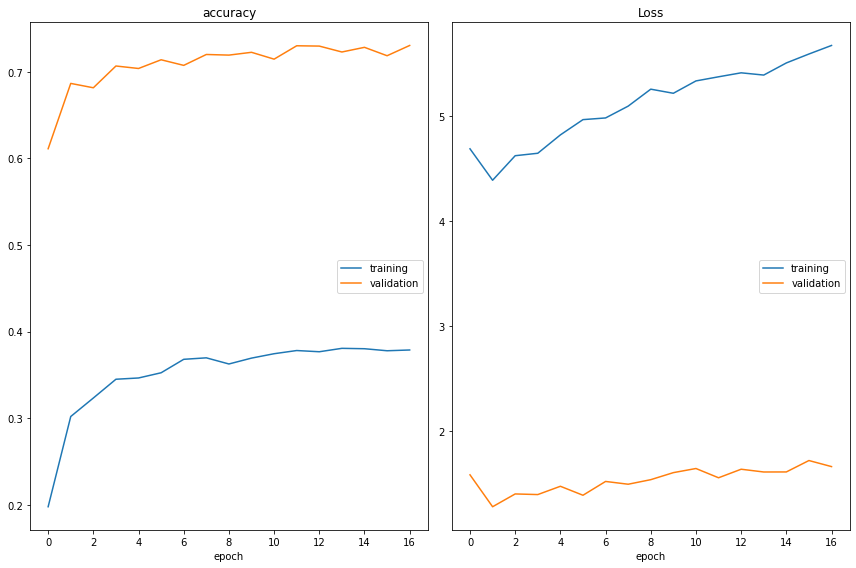

accuracy
	training         	 (min:    0.198, max:    0.381, cur:    0.379)
	validation       	 (min:    0.611, max:    0.730, cur:    0.730)
Loss
	training         	 (min:    4.391, max:    5.677, cur:    5.677)
	validation       	 (min:    1.276, max:    1.717, cur:    1.659)
Epoch 00017: early stopping
84/84 [==============================] - 49s 583ms/step - loss: 1.6407 - accuracy: 0.7078

===== EVALUATE =====

test loss, test acc: [1.64071786403656, 0.7078148126602173]


Execution Time: 05:27:30
CPU times: user 5h 6min 47s, sys: 17min 42s, total: 5h 24min 30s
Wall time: 5h 27min 30s


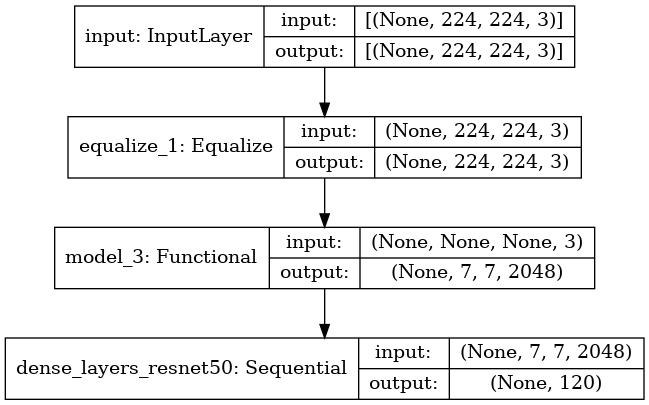

In [17]:
%%time
start = time.time()

build_model = functools.partial(hyper_model_gen,models={'my_pretrained_resnet50':my_pretrained_resnet50},num_classes=nb_classes)

(res_hist,res_eval,res_params,res_fig) = tune_fit_and_evaluate(
    hyper_model=build_model,
    model_name='my_pretrained_resnet50',
    train_ds=train_ds,
    val_ds=val_ds,
    test_ds=test_ds
)

end = time.time()
res_time = exec_time(start,end)
res_fig

#### Tune and Fit ViT model

#### Vision Transformer

In [18]:
def my_pretrained_vit_model(hp,mode,num_classes,
    handle="https://tfhub.dev/sayakpaul/vit_s16_fe/1"):
    
    hub_layer = tfhub.KerasLayer(handle,trainable=False)

    model = tf.keras.Sequential(
        name="myViT",
        layers= [
            tf.keras.layers.InputLayer(IMG_SIZE + (3,)),
            Equalize(dynamic=True),
            tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1),
            hub_layer,
            soft_max(units=num_classes)
        ]
    )
    
    model.compile(loss="categorical_crossentropy",
            metrics=["accuracy"],
            optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate(hp,mode))
          )
    
    return model

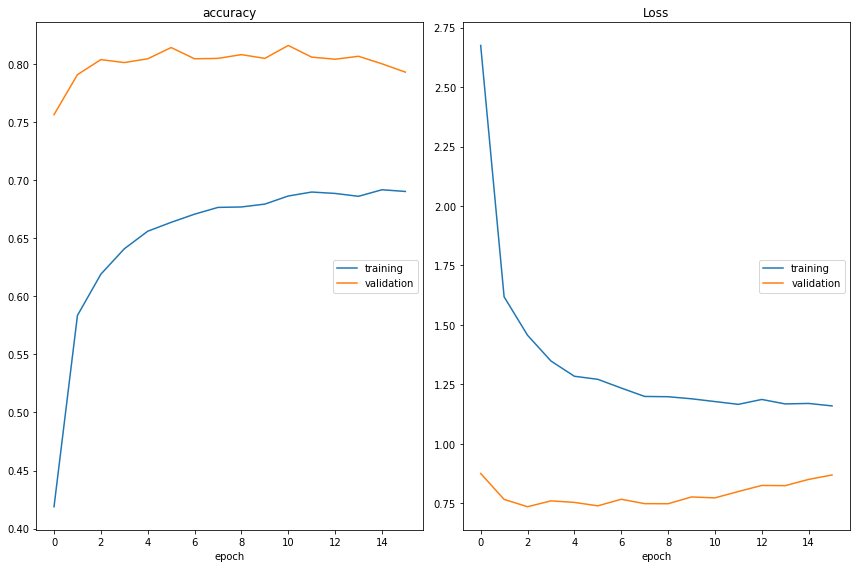

accuracy
	training         	 (min:    0.419, max:    0.692, cur:    0.690)
	validation       	 (min:    0.757, max:    0.816, cur:    0.793)
Loss
	training         	 (min:    1.159, max:    2.675, cur:    1.159)
	validation       	 (min:    0.735, max:    0.875, cur:    0.869)
Epoch 00016: early stopping
84/84 [==============================] - 55s 647ms/step - loss: 0.7562 - accuracy: 0.8084

===== EVALUATE =====

test loss, test acc: [0.75617516040802, 0.8083623647689819]


Execution Time: 05:29:10
CPU times: user 4h 43min 50s, sys: 17min 54s, total: 5h 1min 45s
Wall time: 5h 29min 9s


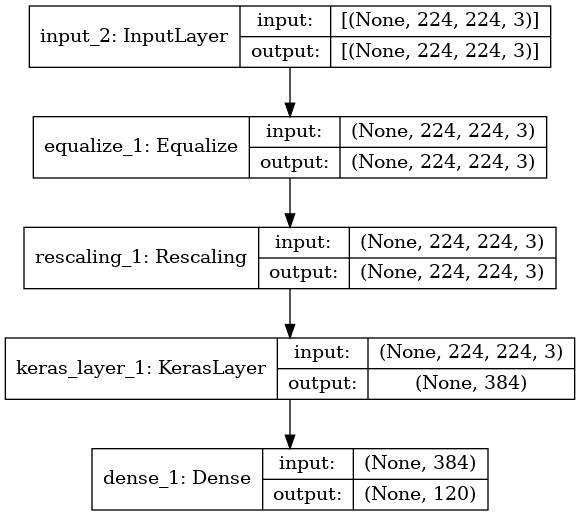

In [19]:
%%time
start = time.time()

build_model = functools.partial(hyper_model_gen,models={'my_pretrained_vit_model':my_pretrained_vit_model},num_classes=nb_classes)

(vit_hist,vit_eval,vit_params,vit_fig) = tune_fit_and_evaluate(
    hyper_model=build_model,
    model_name='my_pretrained_vit_model',
    train_ds=train_ds,
    val_ds=val_ds,
    test_ds=test_ds
)

end = time.time()
vit_time = exec_time(start,end)
vit_fig